# Mars: UV nadir-viewing measurement 

In this notebook, we show an example of how to compute a forward model of the atmosphere of Mars with archNEMESIS in the UV-visible spectral range, including absorption by the Hartley band of ozone and scattering by dust particles in the atmosphere. This is similar to the measurements made by the NOMAD-UVIS spectrometer aboard the ExoMars Trace Gas Orbiter [(Mason et al., 2024)](https://doi.org/10.1029/2023JE008270).

In addition, we perform a comparison of the foward model outputs against the DISORT radiative transfer code [(Stamnes et al., 1988)](https://doi.org/10.1364/AO.27.002502).

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import archnemesis as ans
import h5py

## 1. Inspecting the input files

In [2]:
# Read the archNemesis hdf5 input file
inp_dir = './'
runname = 'archnemesis_disort_comparison_input'
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.Files.read_input_files_hdf5(inp_dir+runname)

### Normalising the ozone abundance

In this example, we want to calculate the spectra of the Martian atmosphere at different ozone column densities. The units of the column density are generally m$^{-2}$, but ozone measurements are often reported in $\mu$m-atm, which correspond to 1 $\mu$m-atm = 2.689 $\times$ 10$^{19}$ m$^{-2}$. Since in our example we want to vary the ozone density in these units, we are going to normalise the column density of ozone to 1 $\mu$m-atm so that it is later on easy to apply a scaling factor and get our desired ozone amounts.

In [3]:
#Estimating the atmospheric column density from the Atmosphere
coldens = Atmosphere.calc_coldens()

#Locating the index of ozone
iO3 = np.where((Atmosphere.ID==3) & (Atmosphere.ISO==0))[0][0]   

#Normalising the O3 column density to 1 um-atm
ozone_coldens = coldens[iO3]
print(ozone_coldens/2.689e19)
Atmosphere.update_gas(3,0,Atmosphere.VMR[:,iO3]/ozone_coldens*2.689e19)  

#Calculating again the column density to make sure it is normalised to 1 um-atm
coldens = Atmosphere.calc_coldens()
print('Ozone column density = ',coldens[iO3],'m-2 = ',coldens[iO3]/2.689e19,' um-atm')

1.0
Ozone column density =  2.689e+19 m-2 =  1.0  um-atm


### Normalising the dust optical depth to 0.67 $\mu$m

The units of the aerosol density profiles in archNEMESIS are generally m$^{-3}$ (if working with the HDF5 files), meaning that the column density of dust will be calculated in m$^{-2}$. Similarly, the units of the extinction cross section in the Scatter class are generally cm$^{2}$, so that when the extinction cross section is multiplied by the dust column density, we calculate the optical depth.

In some cases, it is useful to normalise our profiles so that we can easily define the column-integrated optical depth of the aerosol at a given wavelength. To do so, we need to do some transformations so that all the calculations stay consistent throughout the code.

In particular, we need to normalise the extinction cross section (Scatter.KEXT) to a wavelength of our choice. Then, we need to normalise our aerosol density profile (Atmosphere.DUST), so that the calculations are correctly performed. 

In this example, we show how to easily perform this normalisation in archNEMESIS with our example: we will normalise the profile to an optical depth of 1 at 0.67 $\mu$m.

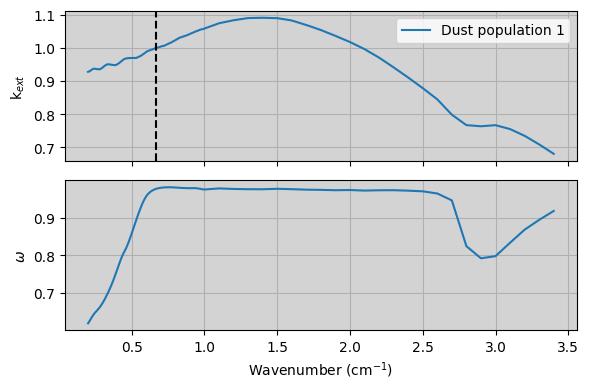

In [4]:
#Normalising the extinction coefficient to 1 at 0.67 um
idust = 0  #We select the index of the aerosol population we want to normalise
vnorm = 0.67
kext_norm = np.interp(vnorm,Scatter.WAVE,Scatter.KEXT[:,idust])
Scatter.KEXT[:,idust] /= kext_norm

#Normalising the aerosol density
Atmosphere.normalise_dust(idust=idust)

#Making summary plot
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(6,4),sharex=True)

for i in range(Scatter.NDUST):
 
    ax1.plot(Scatter.WAVE,Scatter.KEXT[:,i],label='Dust population '+str(i+1))
    ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,i])

ax1.axvline(vnorm,c='black',linestyle='--')
ax1.legend()
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
ax1.grid()
ax2.grid()
ax2.set_xlabel('Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('k$_{ext}$')
ax2.set_ylabel('$\omega$')
plt.tight_layout()

## 2. Loading the DISORT modelled spectra

Here, we read the file with the outputs from DISORT. The spectra for DISORT was calculated using the information from the archNEMESIS HDF5 file, so that the calculations from the two codes are comparable. Here, we read the file and plot the outputs to inspect the information about the cases that were run with DISORT.

In [5]:
# Load the DISORT file that contains the output from the DISORT raidative transfer model
with h5py.File('archNEMEIS-DISORT_spectra.h5','r') as f:
    WAVE = f['OZONE']['WAVE'][:]  #Wavelength array (um)
    DUST_TAU_ARRAY = f['DUST']['DUST_ARRAY'][:]  #Optical depths at which the spectra were computed
    OZONE_ARRAY = f['OZONE']['OZONE_ARRAY'][:] #Ozone densities at which the spectra were computed (um-atm)
    DISORT_OZONE = f['OZONE']['SPECTRA'][:] #Spectra for the different ozone cases (I/F)
    DISORT_DUST = f['DUST']['SPECTRA'][:] #Spectra for the different dust cases (I/F)
    SOLSPEC = f['OZONE']['SOLAR_SPECTRUM'][:] #Solar spectrum used in the calculations

print('Ozone amounts in DISORT calculations',OZONE_ARRAY,'um-atm')
print('Dust optical depths in DISORT calculations',DUST_TAU_ARRAY,'um-atm')

Ozone amounts in DISORT calculations [1.0e-02 5.0e+00 1.5e+01 3.0e+01] um-atm
Dust optical depths in DISORT calculations [0.01 0.5  1.   2.  ] um-atm


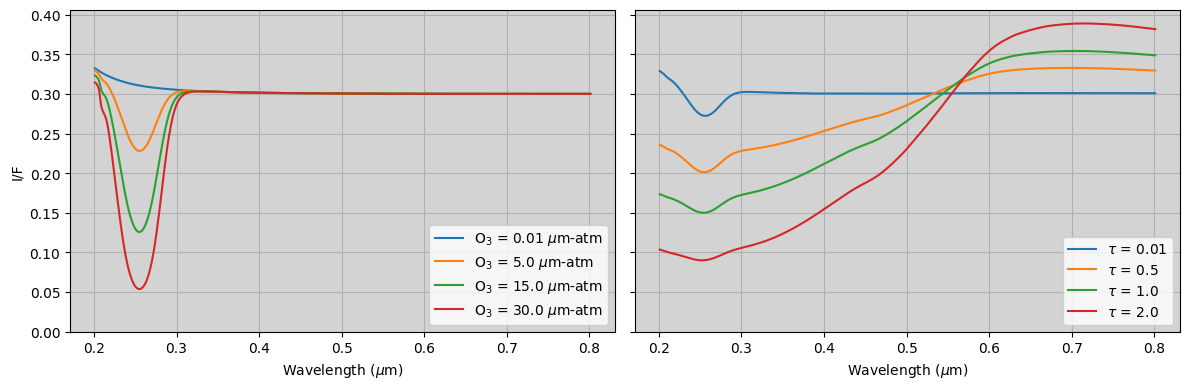

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4),sharey=True)

for i in range(len(OZONE_ARRAY)):
    ax1.plot(WAVE[:,0],DISORT_OZONE[:,i],label='O$_3$ = '+str(OZONE_ARRAY[i])+' $\mu$m-atm')

for i in range(len(DUST_TAU_ARRAY)):
    ax2.plot(WAVE[:,0],DISORT_DUST[:,i],label=r'$\tau$ = '+str(DUST_TAU_ARRAY[i]))

ax1.set_ylim(bottom=0.0)
ax1.grid()
ax1.set_facecolor('lightgray')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('I/F')
ax1.legend()

ax2.set_ylim(bottom=0.0)
ax2.grid()
ax2.set_facecolor('lightgray')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.legend()

plt.tight_layout()

## 3. Running forward model for varying ozone amounts

In this section, we are going to run the forward model of archNEMESIS and vary the ozone column density to compare the outputs against DISORT. In particular, since we have normalised our ozone profile to a column density of 1 $\mu$-atm, we can easily modify the column density by using model parameterisation 2 (i.e., scaling factor of atmospheric profile). In particular, since we want to apply this to ozone, Variables.VARIDENT should be (3,0,2). 

Similarly, since we have normalised the optical depth of the dust column to 1, we can easily modify it by applying a scaling factor to the dust (i.e., Variables.VARIDENT = (-1,0,2)). In this part, we are going to set this scaling factor to zero to focus on the variation of the spectrum with ozone.

In [7]:
#Checking the model parameterisations chosen in our .apr file
print(Variables.VARIDENT)

[[-1  0  2]
 [ 3  0  2]]


In [8]:
# Define the output arrays
SPECONV_ozone = np.zeros((Measurement.VCONV.shape[0],len(OZONE_ARRAY)))   #NEMESIS spectrum in I/F units
for i in range(len(OZONE_ARRAY)):

    #Changing the parameters in the state vector to our desired scaling factor
    Variables.XA[0] = 0.0 ; Variables.XN[0] = 0.0    #We set the dust optical depth to 0.01 
    Variables.XA[1] = OZONE_ARRAY[i] ; Variables.XN[1] = OZONE_ARRAY[i]  # Update the ozone abundance in the Variables class

    #Load ForwardModel class
    ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)

    # Setup the archNemesis forward model
    SPECONVx = ForwardModel.nemesisfm()    # Run the archNemesis foward model
    SPECONV_ozone[:,i] = np.pi * SPECONVx[:,0] / SOLSPEC[:,i]   # Compute the radiance factor by dividing by the solar spectrum (Loaded from the DISORT file)

CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201


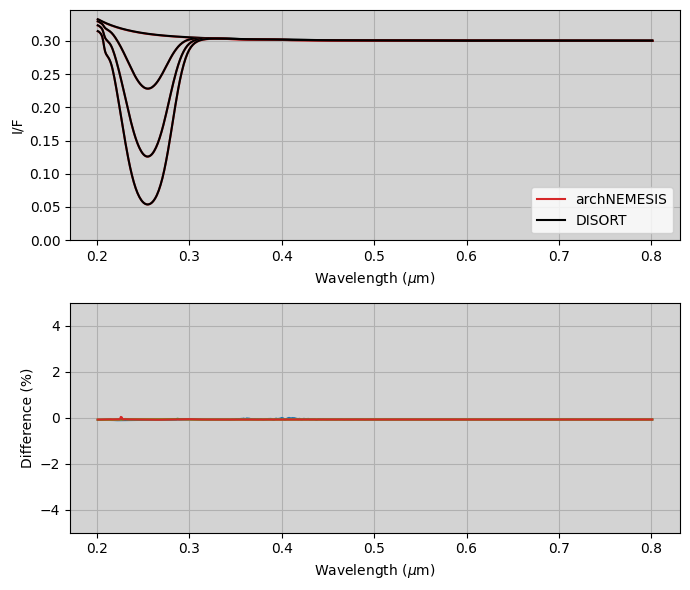

In [9]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7,6))

for i in range(len(OZONE_ARRAY)):

    if i==0:
        ax1.plot(Measurement.VCONV[:,0],SPECONV_ozone[:,i],c='tab:red',label='archNEMESIS')
        ax1.plot(WAVE[:,0],DISORT_OZONE[:,i],c='black',label='DISORT')
    else:
        ax1.plot(Measurement.VCONV[:,0],SPECONV_ozone[:,i],c='tab:red')
        ax1.plot(WAVE[:,0],DISORT_OZONE[:,i],c='black')

    ax2.plot(Measurement.VCONV[:,0],(SPECONV_ozone[:,i]-DISORT_OZONE[:,i])/DISORT_OZONE[:,i]*100.)

ax1.set_ylim(bottom=0.0)
ax1.grid()
ax1.set_facecolor('lightgray')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('I/F')
ax1.legend()

ax2.set_ylim(-5.,5.)
ax2.grid()
ax2.set_facecolor('lightgray')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_ylabel('Difference (%)')

plt.tight_layout()

## 4. Running forward model for varying dust optical depths

Similar to the previous section, we can run the forward model at different dust optical depths by applying a varying scaling factor for the dust, given that we have normalised our profiles to an optical depth of 1 at 0.67 $\mu$m. The ozone column in this case is set to 2 $\mu$m-atm.

In [10]:
# Define the output arrays
SPECONV_dust = np.zeros((Measurement.VCONV.shape[0],len(DUST_TAU_ARRAY)))   #NEMESIS spectrum in I/F units
for i in range(len(OZONE_ARRAY)):

    #Changing the parameters in the state vector to our desired scaling factor
    Variables.XA[0] = DUST_TAU_ARRAY[i] ; Variables.XN[0] = DUST_TAU_ARRAY[i]   # Update the dust optical depth in the Variables class
    Variables.XA[1] = 2. ; Variables.XN[1] = 2.    #We set the ozone column to 2. um-atm
    #Load ForwardModel class
    ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)

    # Setup the archNemesis forward model
    SPECONVx = ForwardModel.nemesisfm()    # Run the archNemesis foward model
    SPECONV_dust[:,i] = np.pi * SPECONVx[:,0] / SOLSPEC[:,i]   # Compute the radiance factor by dividing by the solar spectrum (Loaded from the DISORT file)

CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.00947053]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.47352657]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [0.94705315]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201
CIRSrad :: CIA not included in calculations
CIRSrad :: Aerosol optical depths at  0.2014500037766993  ::  [1.89410629]
CIRSrad :: Performing multiple scattering calculation
CIRSrad :: NF =  20 ; NMU =  16 ; NPHI =  201


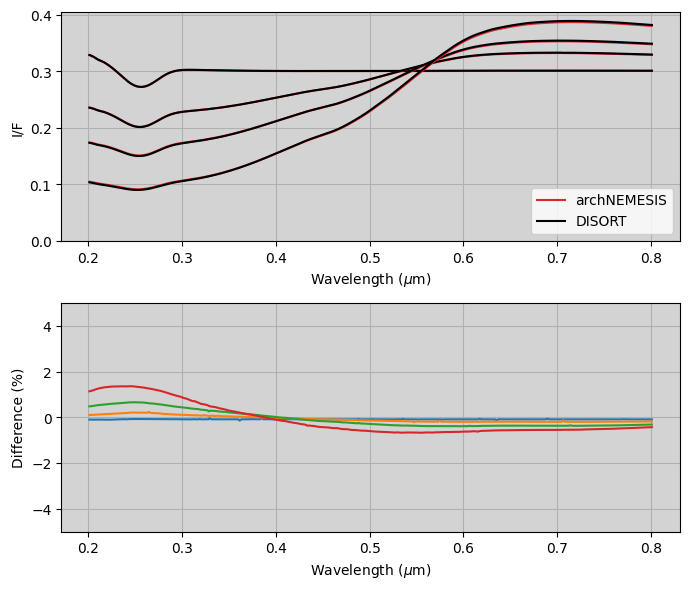

In [11]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(7,6))

for i in range(len(DUST_TAU_ARRAY)):

    if i==0:
        ax1.plot(Measurement.VCONV[:,0],SPECONV_dust[:,i],c='tab:red',label='archNEMESIS')
        ax1.plot(WAVE[:,0],DISORT_DUST[:,i],c='black',label='DISORT')
    else:
        ax1.plot(Measurement.VCONV[:,0],SPECONV_dust[:,i],c='tab:red')
        ax1.plot(WAVE[:,0],DISORT_DUST[:,i],c='black')

    ax2.plot(Measurement.VCONV[:,0],(SPECONV_dust[:,i]-DISORT_DUST[:,i])/DISORT_DUST[:,i]*100.)

ax1.set_ylim(bottom=0.0)
ax1.grid()
ax1.set_facecolor('lightgray')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('I/F')
ax1.legend()

ax2.set_ylim(-5.,5.)
ax2.grid()
ax2.set_facecolor('lightgray')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_ylabel('Difference (%)')

plt.tight_layout()